In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.metrics import CategoricalAccuracy

# Swish activation function
def swish(x):
    return x * tf.keras.backend.sigmoid(x)

# Step 1: Load and preprocess the FER2013 dataset
data = pd.read_csv("fer2013.csv")
data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()
num_classes = len(data['emotion'].unique())
def CRNO(df, dataName):
    #df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel_sequence.split()])
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1, 48, 48, 1) / 255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    print(dataName, f"_X shape: {data_X.shape}, ", dataName, f"_Y shape: {data_Y.shape}")
    return data_X, data_Y

 

train_X, train_Y = CRNO(data_train, "train")  # training data
val_X, val_Y = CRNO(data_val, "val")  # validation data
test_X, test_Y = CRNO(data_test, "test")  # test data

2024-05-31 02:07:39.208810: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


train _X shape: (28709, 48, 48, 1),  train _Y shape: (28709, 7)
val _X shape: (3589, 48, 48, 1),  val _Y shape: (3589, 7)
test _X shape: (3589, 48, 48, 1),  test _Y shape: (3589, 7)


In [2]:
from tensorflow.keras.layers import Activation, Convolution2D, Dropout, Conv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2


def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model


if __name__ == "__main__":
    input_shape = (48, 48, 1)
    num_classes = 7
    model = mini_XCEPTION(input_shape, num_classes)
    model.summary()


2024-05-31 02:08:27.499001: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-31 02:08:27.524161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-31 02:08:27.524412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:14:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 871.81GiB/s
2024-05-31 02:08:27.524430: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-05-31 02:08:27.527379: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-31 02:08:27.527470: I tensorflow/stream_executor/pl

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [3]:
import warnings
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings(action='ignore')
from tensorflow.keras.callbacks import CSVLogger,EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras import callbacks

# 参数
batch_size = 32
num_epochs = 150
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
patience = 50
base_path = 'autodl-tmp/models/mini/'

# 构建模型
model = mini_XCEPTION(input_shape, num_classes)
model.compile(optimizer='adam',  # 优化器采用adam
              loss='categorical_crossentropy',  # 多分类的对数损失函数
              metrics=['accuracy'])
#model.summary()

# 定义回调函数 Callbacks 用于训练过程
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)


checkpoint_cb = callbacks.ModelCheckpoint( "autodl-tmp/models/mini/mini_best_model.h5",  save_best_only=True,  monitor='val_accuracy',  mode='max')

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=15,mode='min', restore_best_weights=True)
reduce_lr =callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,patience=int(patience / 4),verbose=1)
'''
# 模型位置及命名
trained_models_path = base_path + 'mini_Xception'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'

# 定义模型权重位置、命名等
model_checkpoint = ModelCheckpoint(model_names,'val_accuracy', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]
'''
 

# 图片产生器，在批量中对数据进行增强，扩充数据集大小
data_generator = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=.1,
    horizontal_flip=True)

# 利用数据增强进行训练
history=model.fit( data_generator.flow(train_X, train_Y, batch_size=32),
                    #steps_per_epoch=len(train_X) / batch_size,
                    epochs=num_epochs,
                    verbose=1, 
                    callbacks=[checkpoint_cb,early_stop,reduce_lr],
                    validation_data=(val_X, val_Y))

2024-05-31 02:08:32.306804: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-31 02:08:32.307160: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2800040000 Hz


Epoch 1/150


2024-05-31 02:08:33.394762: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-31 02:08:34.003799: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2024-05-31 02:08:34.813346: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-31 02:08:35.350977: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


898/898 [==============================] - 14s 12ms/step - loss: 1.8577 - accuracy: 0.2765 - val_loss: 1.7471 - val_accuracy: 0.3742
Epoch 2/150
898/898 [==============================] - 10s 12ms/step - loss: 1.6124 - accuracy: 0.3869 - val_loss: 1.7870 - val_accuracy: 0.4012
Epoch 3/150
898/898 [==============================] - 10s 12ms/step - loss: 1.4931 - accuracy: 0.4346 - val_loss: 1.5850 - val_accuracy: 0.4087
Epoch 4/150
898/898 [==============================] - 10s 12ms/step - loss: 1.4135 - accuracy: 0.4646 - val_loss: 1.4027 - val_accuracy: 0.4778
Epoch 5/150
898/898 [==============================] - 11s 12ms/step - loss: 1.3599 - accuracy: 0.4842 - val_loss: 1.5212 - val_accuracy: 0.4625
Epoch 6/150
898/898 [==============================] - 10s 12ms/step - loss: 1.3234 - accuracy: 0.5028 - val_loss: 1.4417 - val_accuracy: 0.4734
Epoch 7/150
898/898 [==============================] - 10s 12ms/step - loss: 1.2990 - accuracy: 0.5115 - val_loss: 1.3981 - val_accuracy: 0.48

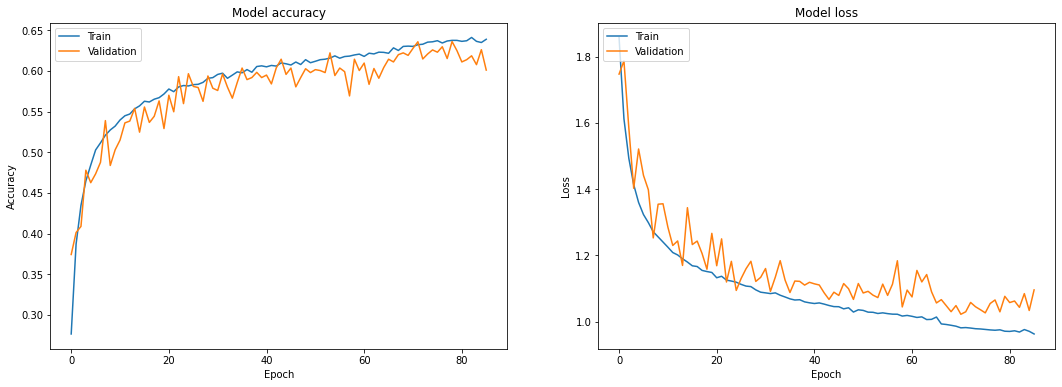

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# 绘制训练和验证精度曲线
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# 绘制训练和验证损失曲线
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [5]:
from sklearn.metrics import accuracy_score
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

Model Accuracy on test set: 0.6314


2024-05-31 02:27:38.789509: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23390257152 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
